In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate, cross_val_score, learning_curve, ShuffleSplit

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(42)
plt.style.use('seaborn')

In [3]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [4]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

In [5]:
print(f"Shape of feature matrix is {features.shape}")
print(f"Shape of label vector is {labels.shape}")

Shape of feature matrix is (20640, 8)
Shape of label vector is (20640,)


In [6]:
assert (features.shape[0] == labels.shape[0])

In [7]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

In [8]:
print(f"#trainings samples: {train_features.shape[0]}")
print(f"#test samples: {test_features.shape[0]}")

#trainings samples: 15480
#test samples: 5160


In [9]:
line_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])

line_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

In [10]:
print(f"Intercept(w0): {line_reg_pipeline[-1].intercept_}")
print(f"weight vector(w1, w2, ..., wm): {line_reg_pipeline[-1].coef_}")

Intercept(w0): 2.0703489205426377
weight vector(w1, w2, ..., wm): [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


In [11]:
# Evaluation on model
test_score = line_reg_pipeline.score(test_features, test_labels)
print(f"Model performance on test set: {test_score}")

train_score = line_reg_pipeline.score(train_features, train_labels)
print(f"Model performance on train set: {train_score}")

Model performance on test set: 0.5910509795491352
Model performance on train set: 0.609873031052925


Low r2 score points to underfitting

TO confirm the score, let's calculate the cross_validation score

In [12]:
lin_reg_score = cross_val_score(line_reg_pipeline, train_features, train_labels, scoring='neg_mean_squared_error', cv=shuffle_split_cv)

print(lin_reg_score) # this is a list of 10 scores, since the Shuffle split performed 10 splits.
print(f"Score of linear regression model on test set:\n {lin_reg_score.mean()} +/- {lin_reg_score.std()}")

[-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]
Score of linear regression model on test set:
 -0.5287517875396764 +/- 0.022232904569798696


In [13]:
lin_reg_mse = -lin_reg_score
print(f"MSE of linear regression model on test set:\n {lin_reg_mse.mean()} +/- {lin_reg_mse.std()}")

MSE of linear regression model on test set:
 0.5287517875396764 +/- 0.022232904569798696


Alternatively, use cross_validate API.  This can return the models trained on each fold with train error for that fold.

In [14]:
lin_reg_cv_results = cross_validate(line_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv, 
                                    scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True)

In [15]:
lin_reg_cv_results # There are 10 values for each key, one for each fold.

{'fit_time': array([0.01017451, 0.00803709, 0.00698256, 0.00872517, 0.00915742,
        0.00698256, 0.00981092, 0.00793505, 0.01009083, 0.00797868]),
 'score_time': array([0.00180912, 0.00300097, 0.00199342, 0.00202894, 0.00199676,
        0.00299573, 0.00187492, 0.00201344, 0.00199676, 0.00199556]),
 'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('featu

In [16]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error = -1 * lin_reg_cv_results['test_score']

print(f'Mean squared error of linear regression model on the training set is {train_error.mean()} +/- {train_error.std()}')
print(f'Mean squared error of linear regression model on the test set is {test_error.mean()} +/- {test_error.std()}')

Mean squared error of linear regression model on the training set is 0.5186840759388985 +/- 0.0055522490673909275
Mean squared error of linear regression model on the test set is 0.5287517875396764 +/- 0.022232904569798696


In [17]:
train_features.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

<AxesSubplot:>

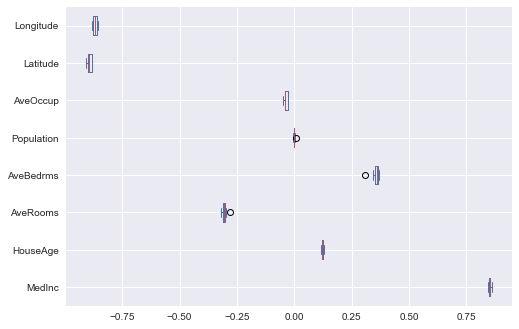

In [18]:
coefs = [est[-1].coef_ for est in lin_reg_cv_results['estimator']]
weights_df = pd.DataFrame(coefs, columns=train_features.columns)

weights_df.plot.box(vert=False)

In [19]:
weights_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.852153,0.122770,-0.304384,0.353528,-0.001576,-0.037059,-0.894011,-0.869753
std,0.005763,0.004312,0.010998,0.018044,0.003254,0.008582,0.009975,0.009097
min,0.843517,0.117394,-0.318971,0.307474,-0.005787,-0.047584,-0.908058,-0.884206
25%,0.848871,0.119895,-0.310778,0.349715,-0.002688,-0.042486,-0.901411,-0.876542
50%,0.852711,0.121592,-0.305795,0.360139,-0.002063,-0.042325,-0.895370,-0.869631
75%,0.854743,0.125520,-0.302980,0.364646,-0.000350,-0.027562,-0.883967,-0.862110
max,0.861659,0.130560,-0.278426,0.367952,0.005297,-0.026331,-0.881884,-0.857844


Note that variance of the features AveRooms and AveBedrms are higher than the others.  Also, Population seems to have outliers, since the 75% percentile is significantly different from the max value.

In order to the find the best model, locate the estimator among all the folds that returned the least test error

In [20]:
test_error

array([0.50009976, 0.52183352, 0.55931218, 0.52110499, 0.56059203,
       0.50510767, 0.52386194, 0.54775518, 0.5007161 , 0.54713448])

In [21]:
selected_model = lin_reg_cv_results['estimator'][np.argmin(test_error)]

The model coefficients of the best model are:

In [22]:
print(f"Intercept(w0): {selected_model[-1].intercept_}")
print(f"Intercept(w0): {selected_model[-1].coef_}")

Intercept(w0): 2.0779898917958657
Intercept(w0): [ 8.44324888e-01  1.18463901e-01 -3.04619574e-01  3.56620503e-01
  1.74458509e-04 -4.23964612e-02 -8.96045642e-01 -8.68906479e-01]


See how the actual and predicted labels for the training set differs

Text(0.5, 1.0, 'Mean squared error = 0.52')

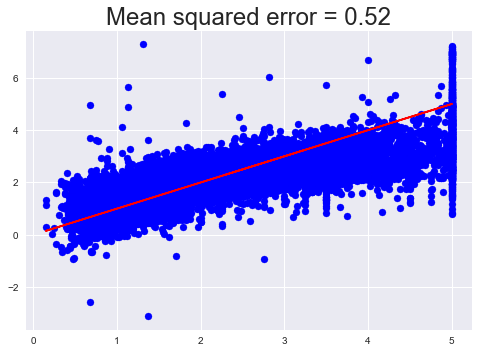

In [23]:
from sklearn.model_selection import cross_val_predict

cv_predictions = cross_val_predict(line_reg_pipeline, train_features, train_labels)
plt.scatter(train_labels, cv_predictions, color='blue')
plt.plot(train_labels, train_labels, 'r-')

mse_cv = mean_squared_error(train_labels, cv_predictions)
plt.title(f"Mean squared error = {mse_cv:.2f}", size=24)

Once the final model has been selected, use it to predict on test_features

In [24]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv[:5]

array([0.73548515, 1.7725621 , 2.70011199, 2.83716602, 2.60743151])

Compare the above with the predictions on same test_features we built without cross-validation

In [25]:
test_predictions = line_reg_pipeline.predict(test_features)
test_predictions[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

In [26]:
# Evaluation on the selected model
test_score = selected_model.score(test_features, test_labels)
print(f"Model performance on test set: {test_score}")

train_score = selected_model.score(train_features, train_labels)
print(f"Model performance on train set: {train_score}")

Model performance on test set: 0.5923577635319088
Model performance on train set: 0.6098001134259827


In [27]:
# Evaluation on original model (without cross-validation).  This was calculated above also
test_score = line_reg_pipeline.score(test_features, test_labels)
print(f"Model performance on test set: {test_score}")

train_score = line_reg_pipeline.score(train_features, train_labels)
print(f"Model performance on train set: {train_score}")

Model performance on test set: 0.5910509795491352
Model performance on train set: 0.609873031052925


Note that the test scores are marginally higher with cross validation

In [28]:
result = learning_curve(line_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv, scoring='neg_mean_squared_error', 
                        n_jobs=-1, return_times=True, train_sizes=np.linspace(0.2, 1.0, 10))
                        
(train_sizes, train_scores, test_scores, fit_times, score_times) = result
                        
for (size, train_score, test_score) in zip(train_sizes, train_scores, test_scores):
    print(f"For a training set with {size} samples:\n",
          f"\t\ttrain score is {[round(each,3) for each in train_score]}\n",
          f"\t\ttest score is {[round(each,3) for each in test_score]}")

For a training set with 2476 samples:
 		train score is [-0.497, -0.47, -0.445, -0.488, -0.485, -0.51, -0.475, -0.51, -0.455, -0.449]
 		test score is [-0.508, -2.848, -0.525, -0.522, -0.566, -30.543, -0.528, -0.569, -24.533, -2.647]
For a training set with 3577 samples:
 		train score is [-0.496, -0.501, -0.449, -0.5, -0.498, -0.513, -0.503, -0.508, -0.472, -0.456]
 		test score is [-0.506, -0.526, -0.525, -0.522, -0.565, -21.847, -0.525, -0.554, -19.319, -2.18]
For a training set with 4678 samples:
 		train score is [-0.505, -0.516, -0.49, -0.512, -0.509, -0.513, -0.505, -0.508, -0.485, -0.525]
 		test score is [-0.505, -0.522, -0.559, -0.521, -0.565, -13.683, -0.523, -0.554, -24.286, -0.547]
For a training set with 5779 samples:
 		train score is [-0.513, -0.518, -0.489, -0.515, -0.511, -0.511, -0.519, -0.512, -0.482, -0.527]
 		test score is [-0.504, -0.521, -0.559, -0.522, -0.563, -18.132, -0.522, -0.551, -25.942, -0.548]
For a training set with 6880 samples:
 		train score is [-0